# L4 – Word embedding

### Resources
1. Possible [truncated svd](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) implementation of sklearn.
2. Tensorflow [tutorial](https://www.tensorflow.org/tutorials/word2vec) for word2vec and [implementation](https://github.com/tensorflow/models/tree/master/tutorials/embedding).
3. GloVe [site](https://nlp.stanford.edu/projects/glove/).
4. FastText [site](https://fasttext.cc).
5. [Gensim](https://radimrehurek.com/gensim/) library.

**Word embedding** – the collective name for a set of language modeling and feature learning techniques in natural language processing where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with much higher dimensionality. Word and phrase embeddings, when used as the underlying input representation, have been shown to boost the performance in NLP tasks such as syntactic parsing, sentiment analysis and translation. Usually, problem reduces to unsupervised learning on a large corpus of text. So, learning process is based on the idea that context of word closely associated with it. For example, the context can be a document in which the word is located or adjacent words.

### 1. Data

As text corpus you may use simple english [wikipedia](https://simple.wikipedia.org/wiki/Simple_English_Wikipedia).
1. 131K articles
2. 2K common English words.

Also you can use just english [wikipedia](https://en.wikipedia.org/wiki/Wikipedia):
1. Includes 5М+ articles
2. 2M+ different tokens

#### Exercises
1. Download all wikipedia articles.
2. Make all preprocessing work that you need (e.g. remove markup).

In [1]:
import tensorflow as tf
import gensim
import pattern
import sklearn.decomposition
import scipy.sparse
from scipy.spatial.distance import cdist
import numpy as np
import collections
from collections import defaultdict
from tqdm import tqdm
import random
from random import *
import pickle

from gensim.corpora import WikiCorpus, MmCorpus, Dictionary
from gensim import corpora, models, similarities
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

We will filter out words which are found is less than 7 articles and those which are attributed to more than 40% of all articles in corpus.

In [ ]:
DUMP_NAME = "simplewiki-20180201-pages-articles.xml.bz2"
wiki_corpus = WikiCorpus(DUMP_NAME, lemmatize=False)
wiki_corpus.dictionary.filter_extremes(no_below=7, no_above=0.4, keep_n=100000)
wiki_corpus.dictionary.save('filtered_wiki.dict')

In [47]:
wiki_corpus.save('simple_wiki_corpus')

/usr/local/lib/python3.5/dist-packages/gensim/interfaces.py:60: UserWarning: corpus.save() stores only the (tiny) iteration object; to serialize the actual corpus content, use e.g. MmCorpus.serialize(corpus)
  "corpus.save() stores only the (tiny) iteration object; "
2018-02-09 16:56:14,530 : INFO : saving WikiCorpus object under simple_wiki_corpus, separately None
2018-02-09 16:56:14,572 : INFO : saved simple_wiki_corpus


In [3]:
wiki_corpus = WikiCorpus.load('simple_wiki_corpus')

2018-02-11 11:28:22,557 : INFO : loading WikiCorpus object from simple_wiki_corpus
2018-02-11 11:28:22,771 : INFO : loading dictionary recursively from simple_wiki_corpus.dictionary.* with mmap=None
2018-02-11 11:28:22,772 : INFO : loaded simple_wiki_corpus


### 2. LSA (Latent semantic analysis)
This solution uses full document as a context of word. So, we have some vocabulary $W$ and a set of documents $D$. Matrix $X$ with shape $|W| \times |D|$ at position $w, d$ stores importance of word $w$ for document $d$. If word $w$ is not found in the document $d$ than at appropriate position $X$ has 0 (obviously, matrix is sparse).

For each matrix you can find [SVD decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)
$$X = U \Sigma V^{T} \text{, где }$$
* $U$ – orthogonal matrix $|W| \times |W|$ of left singular vectors
* $\Sigma$ – diagonal matrix $|W| \times |D|$ of singular values
* $V$ – orthogonal matrix $|D| \times |D|$  of right singular vectors

Let's suppouse that row $w$ in matrix $U\Sigma$ is a vector that represents word $w$, and row $d$ of $V$ coresponds to document $d$. In some sense we already found the embeddings of words and documents at the same time. But size of vectors are determined by documents number $|D|$.

Nevertheless you can use truncated SVD instead
$$ X \approx X_k = U_k \Sigma_k V^{T}_k \text{, where }$$
* $U_k$ – $k$ left singular vectors
* $\Sigma_k$ – diagonal matrix $|k| \times |k|$ of largest singular values
* $V_k$ – $k$ right singular vectors

Also it known that $X_k$ is the best approximation of $X$ in the term of [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) for all matrices of rank $k$.

So, it is possible to obtain a compressed words' representations of size $k \ll |W|$ as rows of matrix $U_k \Sigma_k $. It just remains to understand how to calculate the original values of the matrix $X$. There is a set of approaches, here are some of them
1. Binary flag that document contains the word.
2. The number occurrences of word in document.
3. Word frequency that is better known as $tf$ (it's possible also use $\ln(1 + tf)$).
4. [$tf \cdot idf$](https://ru.wikipedia.org/wiki/TF-IDF).

#### Further readning
1. You also can read this [aticle](https://en.wikipedia.org/wiki/Latent_semantic_analysis).
2. By the way, some [modification](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf) of SVD decompostion won at [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize).
3. It is easy to see that the problem of SVD decomposition is reduced to finding eigenvectors of matrix $X \cdot X^T$.
4. You can find [here](https://arxiv.org/abs/0909.4061) probabilistic algorithms of matrix decomposition.

#### Exercises
1. Find matrix $X$, using you favourite approach (maybe you need the sparse matrix class of scipy library).
2. Find word embeddings of size $k = 128$.
3. Implement k-nearest neighbor search for Euclidean norm.
4. Find 10 nearest words for the set of words: 'cat', 'loves', 'clever' and 'mandarin'.
5. Repeat experiment for cosinus as metric. What are the results?

Let's firstly find $X$ matrix by using tf-idf approach:

In [ ]:
tfidf = models.TfidfModel(wiki_corpus, id2word=wiki_corpus.dictionary)
wiki_tfidf = tfidf[wiki_corpus]
wiki_sparse = gensim.matutils.corpus2csc(wiki_tfidf)

As we have sparse matrix, we can find word embeddings by reducing dimensionality to $R^{128}$

In [110]:
DIM = 128

In [74]:
svd = sklearn.decomposition.TruncatedSVD(n_components=DIM, n_iter=7, random_state=1773)
embeddings = svd.fit_transform(wiki_sparse)

Let's save embeddings and sparse matrix in order to use them when reloading kernel.

In [81]:
np.save('word_embeddings.npy', embeddings)

In [83]:
with open('wiki_sparse_tfidf.pickle', 'wb') as f:
    pickle.dump(wiki_sparse, f)

We're now ready to implement kNN and play with words:

In [142]:
def get_k_nearest(word, embeddings, dictionary, k, metric):
    def id2word(idx):
        return dictionary[idx]
    
    def word2id(word):
        return dictionary.doc2idx([word])[0]
    
    distances = cdist(embeddings, 
                      embeddings[word2id(word)].reshape(1, embeddings.shape[1]),
                      metric=metric).flatten()
        
    return [(id2word(x), distances[x]) for x in np.argsort(distances)[:k + 1] if x != word2id(word)][:k]

In [143]:
def print_k_nearest(word, embeddings, dictionary, k, metric):
    nearest_list = get_k_nearest(word, embeddings, dictionary, k, metric)
    print('Nearest to', word)
    print('%15s %10s' %('word', 'distance'))
    print('='*30)
    for word_info in nearest_list:
        print("%15s | %.4f" %(word_info[0], word_info[1]))
    print('='*30, end='\n\n')

In [201]:
print_k_nearest('cat', embeddings, wiki_corpus.dictionary, 10, 'euclidean')
print_k_nearest('loves', embeddings, wiki_corpus.dictionary, 10, 'euclidean')
print_k_nearest('clever', embeddings, wiki_corpus.dictionary, 10, 'euclidean')
print_k_nearest('mandarin', embeddings, wiki_corpus.dictionary, 10, 'euclidean')

Nearest to cat
           word   distance
           cats | 0.3558
            dog | 0.4080
          breed | 0.4174
           bear | 0.4245
         spider | 0.4298
           dogs | 0.4322
           eyes | 0.4328
            fur | 0.4356
           duck | 0.4549
     appearance | 0.4558

Nearest to loves
           word   distance
          funny | 0.1129
          likes | 0.1129
           ugly | 0.1254
            mom | 0.1260
      wonderful | 0.1260
           sees | 0.1275
           wish | 0.1280
          knows | 0.1289
          proud | 0.1297
          curse | 0.1308

Nearest to clever
           word   distance
        realize | 0.0395
        jealous | 0.0405
         honest | 0.0435
       persuade | 0.0435
     frightened | 0.0436
          wakes | 0.0441
     dostoevsky | 0.0442
        shocked | 0.0444
          cared | 0.0445
         liking | 0.0446

Nearest to mandarin
           word   distance
     simplified | 0.1181
      cantonese | 0.1386
      taiwanese | 0

Let's change metric to cosine and compare results:

In [195]:
print_k_nearest('cat', embeddings, wiki_corpus.dictionary, 10, 'cosine')
print_k_nearest('loves', embeddings, wiki_corpus.dictionary, 10, 'cosine')
print_k_nearest('clever', embeddings, wiki_corpus.dictionary, 10, 'cosine')
print_k_nearest('mandarin', embeddings, wiki_corpus.dictionary, 10, 'cosine')

Nearest to cat
           word   distance
           cats | 0.1244
            dog | 0.1496
            pet | 0.1554
        kittens | 0.1598
           paws | 0.1783
          tabby | 0.1957
           ears | 0.1993
         rabbit | 0.2100
       whiskers | 0.2102
        siamese | 0.2176

Nearest to loves
           word   distance
         friend | 0.1268
        friends | 0.1354
          happy | 0.1744
           ugly | 0.1892
          funny | 0.1900
          likes | 0.1904
           girl | 0.2024
            mom | 0.2061
       realises | 0.2061
          proud | 0.2093

Nearest to clever
           word   distance
         really | 0.1686
         thinks | 0.1713
        telling | 0.1714
          knows | 0.1721
          angry | 0.1810
        jealous | 0.1847
        realize | 0.1995
          proud | 0.2014
       dislikes | 0.2068
            sad | 0.2099

Nearest to mandarin
           word   distance
      cantonese | 0.0334
     simplified | 0.0863
        hokkien | 0

As we can see, cosine metric performs a little bit better meaning that nearest words are generally more relevant, comparing to results with euclidean metric.

### 3. word2vec
Let's consider perhaps the most popular model of word embeddings. This is mainly due to the fact that the received vectors have interesting properties. In particular, semantically similar words have close vectors, moreover linear operation of subtraction has meaning in the resulting vector space! The context of word at this time is a window of size $2c+1$, where interested word is located in the middle.

#### Continuous bag-of-words
The core idea is very simple. There is some very long text
$$w_1, w_2, \dots, w_T.$$
Consider some word $w_t$ and its context in radius $c$, namely words
$$w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}.$$
Intuition tells us that the context often really well defines the word in the middle. Then let our model restore the central word if its context is known
$$\mathcal{L} = - \frac{1}{T}\sum_{t} \log \mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}].$$

For each word $w_t$ there is some vector $v_t$, but if word $w_{t+i}$ is some context than we use vector $v'_{t+i}$. In this case we can represent context of word as the following sum
$$s'_t = \sum_{c \leq i \leq c, i \neq 0} v'_{t+i}$$

And define probabilty with softmax
$$\mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t-1}, \dots w_{t+c}] = \frac{ \exp {s'}_t^T \cdot v_t}{\sum_j \exp {s'}_t^T \cdot v_j}.$$

Note that this model is easy to present as 2-layer neural network:
* The input is a sparse vector of dimension $|W|$ which at position $w'$ has one if word $w'$ is in context.
* Further, we have matrix $V'$ of vectors $v'$.
* Further, without any non-linearity matrix $V$ of vector $v$.
* And then the softmax layer.

#### Skip-gram
Another model predicts context for some word. The design is approximately the same, we need to optimize
$$\mathcal{L} = -\frac{1}{T} \sum_t \sum_{-c \leq i \leq c, i \neq 0} \mathbb{P}[w_{t+i}|w_t].$$

The probability is approximated by the following model
$$\mathbb{P}[w_{t+i}|w_t] = \frac{ \exp {v'}_{t+i}^T \cdot v_t}{\sum_j \exp {v'}_{j}^T \cdot v_t}.$$


#### Hierarchical softmax
Creation of this mode was guided to reduce the complexity of learning. However, computing of sofmax's denominator is really expensive operation. Therefore, in practice, a few other models are used.

This method was viewed in the seminar. Detailed information can be found [here](http://www.iro.umontreal.ca/~lisa/pointeurs/hierarchical-nnlm-aistats05.pdf) and practical using [here](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).    Briefly recall, for each word from the dictionary we define [Huffman code](https://en.wikipedia.org/wiki/Huffman_coding). More frequency words have shorter code. Then we construct the Huffman tree. In accordance with its code words are stored in leaves. In the non-leaf vertices are stored special hidden representations $h'$. 

$$\mathbb{P}[w_{t+i}|w_t] = \prod_{{h'}_{t+i}, r} \sigma\Big( \mathcal{r} \cdot {h'}^T_{t+i} v_t \Big) \text{, where}$$
* ${h'}_{t+i}$ - hidden vector of word's path $w_{t+i}$
* $\mathcal{r}$ - equals $-1$, if we turn left and $+1$ in another case
* $\sigma$ - sigmoid function

Using hierarchical softmax as approximation of softmax allows us to significantly reduce complexity of model training. 

#### Exercise
1. How can you implement skip-gram model as neural network.
2. Estimate complexity of one iteration of training the skip-gram model
  * $T$ - text size
  * $W$ - vocabulary size
  * $c$ - context radius
  * $d$ - embedding size
3. Estimate complexity of using hierarchical softmax in the skip-gram model.

#### Why sampling?
Let see at softmax funciton
$$\mathbb{P}[x_i] = \frac{\exp f(x_i|\theta)}{\sum_j \exp f(x_j|\theta)}$$
Optimizing this function is equivalent to optimizing its logarithm
$$\log \frac{\exp f(x_i|\theta)}{\sum_j \exp f(x_j|\theta)} = f(x_i|\theta) - log \sum_j \exp f(x_j|\theta)$$
Than gradient $\triangledown_{\theta} \mathbb{P}[x_i]$ is equal to
$$\triangledown_{\theta} f(x_i|\theta) - \sum_k \frac{\exp f(x_k|\theta)}{\sum_j \exp f(w_j|\theta)} \triangledown_{\theta} f(x_k|\theta)$$
Inside the sum we can find $\mathbb{P}[x_k]$ again. So, the previous expression can be written as
$$
\triangledown_{\theta} f(x_i|\theta) - \sum_k \mathbb{P}[x_k] \cdot \triangledown_{\theta} f(x_k|\theta) = 
\triangledown_{\theta} f(x_i|\theta) - \mathbb{E}_{x \sim \mathbb{P}[x]} \triangledown_{\theta} f(x|\theta)
$$
If we can sample $x \sim \mathbb{P}[x]$, then we has no sense to calculate the softmax itself. We just can train model, computing only gradient. It is possible due to the fact that we do not need the probability itself, but want to find representation of words only.

#### Negative Sampling
As the result, in practice, softmax loss functions is approximated with negative sampling, which looks like a series of logistic regressions
$$\mathcal{L} = - \frac{1}{T}\sum_{w_t}
    \sum_{-c \leq i \leq c, i \neq 0} \Big(
        \mathbb{P}[y = 1 | w_{t+i}, w_t] -
        k \cdot \mathbb{E}_{\tilde{w}_{tj} \sim \mathbb{P}[w_j|w_t]} \mathbb{P}[y = 0 | \tilde{w}_{tj}, w_t]
    \Big)
$$
where $y=1$, if  word is a context of word and $y=0$ in another case. А $\tilde{w}_{tj}$ – sampling of words that don't belong to the context. Then main trick is how we will sample words $\mathbb{P}[y | w_{t+i}, w_t]$. In paper [noise contrastive estimation](https://www.cs.helsinki.fi/u/ahyvarin/papers/Gutmann10AISTATS.pdf) some interesting approaches is suggested. But we are going to use more simple variation
$$\mathcal{L} = - \frac{1}{T}\sum_{w_t} \Big(
    \sum_{-c \leq i \leq c, i \neq 0} \big(
        \sigma({v'}_{t+i}^T v_t) +
        k \cdot \mathbb{E}_{w_j \sim \mathbb{Q}(w_j)} \sigma (-{v'}_{j}^T v_t)
    \big)
\Big),
$$
to find  $\mathbb{E}_{\tilde{w}_{tj} \sim \mathbb{P}[w_j|w_t]}$ we simply sample words $k$ times from distribution $\mathbb{Q}$, $\mathbb{P}(w_j|w_t) = \mathbb{Q}(w_j)$.

#### Additional word2vec tricks
For the best quality at the moment of learning it is proposed to use variety of tricks:
1. How to choose $\mathbb{Q}$.
2. Sampling of frequent and rare words.
3. The sampling of window size.
You are welcome to read about this in original papers.

#### Further reading
1. Briefly about both models [here](https://arxiv.org/pdf/1301.3781.pdf).
2. Hierarchical softmax and negative sampling [here](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

#### Exercises
1. Train skip-gram model, using negative sampling and embedding size $d$ = 256. You are free to choose size of window and number of epochs.
2. Find top-10 nearest words again. Compare Euclidean and cosinus metric. Which is better? 
3. Find 10 nearest vector for expression v(king) - v(man) + v(women). If your model is tuned well, you find representation of word queen. 
4. How could you solve the following problems?
  * Find for country its capital
  * For a word find its plural form
  * For word define antonyms

In [9]:
filtered_voc = Dictionary.load('filtered_wiki.dict')
vocabulary_set = set(filtered_voc.values())
vocabulary_size = len(vocabulary_set)

2018-02-11 11:32:26,416 : INFO : loading Dictionary object from filtered_wiki.dict
2018-02-11 11:32:26,629 : INFO : loaded filtered_wiki.dict


In [11]:
def build_dataset(corpus, vocabulary):
    words = []
    
    print('INFO: extracting words from corpus')
    for text in tqdm(corpus.get_texts()):
        words.extend([word for word in text if word in vocabulary])
    count = []
    count.extend(collections.Counter(words).most_common())
    dictionary = dict()
    
    print('INFO: creating dictionary')
    for word, _ in tqdm(count):
        dictionary[word] = len(dictionary)
        
    data = list()
    print('INFO: creating dataset')
    for word in tqdm(words):
        index = dictionary[word]
        data.append(index)
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [12]:
t_data, t_count, t_dict, t_rev_dict = build_dataset(wiki_corpus, vocabulary_set)

0it [00:00, ?it/s]

INFO: extracting words from corpus


87304it [01:35, 918.50it/s] 2018-02-10 09:00:53,529 : INFO : finished iterating over Wikipedia corpus of 87384 documents with 23340546 positions (total 243051 articles, 24725459 positions before pruning articles shorter than 50 words)
87384it [01:35, 917.68it/s]
  0%|          | 0/16506837 [00:00<?, ?it/s]

INFO: creating dictionary
INFO: creating dataset


100%|██████████| 16506837/16506837 [00:13<00:00, 1256376.18it/s]


In [17]:
with open('t_data.pickle', 'wb') as f:
    pickle.dump(t_data, f)
with open('t_dict.pickle', 'wb') as f:
    pickle.dump(t_dict, f)
with open('t_rev_dict.pickle', 'wb') as f:
    pickle.dump(t_rev_dict, f)   

In [11]:
with open('t_data.pickle', 'rb') as f:
    t_data = pickle.load(f)
with open('t_dict.pickle', 'rb') as f:
    t_dict = pickle.load(f)
with open('t_rev_dict.pickle', 'rb') as f:
    t_rev_dict = pickle.load(f)

In [62]:
data_index = 0

def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

Size of the whole corpus in words:

In [63]:
len(t_data)

16506837

Initializing our graph:

In [66]:
batch_size = 512
embedding_size = 256
skip_window = 4
num_skips = 8
num_sampled = 64

w2vec_graph = tf.Graph()

with w2vec_graph.as_default():
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal(
            [vocabulary_size, embedding_size],
            stddev=1.0 / np.sqrt(embedding_size)))
        
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    tf.summary.scalar('loss', loss)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [69]:
EPOCHS = 5
num_steps = int((len(t_data) * num_skips * EPOCHS) / batch_size)

In [71]:
with tf.Session(graph=w2vec_graph) as session:
    init.run()
    print('Successfully initialized')

    average_loss = 0
    for step in tqdm(range(num_steps)):
        batch_inputs, batch_labels = generate_batch(t_data, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, loss_val = session.run([optimizer, loss],
                              feed_dict=feed_dict)
        average_loss += loss_val

        if step % 100000 == 0:
            if step > 0:
                average_loss /= 100000
            # The average loss is an estimate of the loss over the last 100000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
    final_embeddings_norm = normalized_embeddings.eval()
    final_embeddings = embeddings.eval()


  0%|          | 0/1289596 [00:00<?, ?it/s]

Successfully initialized


  0%|          | 22/1289596 [00:00<12:29:34, 28.67it/s]

Average loss at step  0 :  282.5571594238281


  8%|▊         | 100030/1289596 [08:14<1:38:05, 202.13it/s]

Average loss at step  100000 :  13.317427683334797


 16%|█▌        | 200041/1289596 [16:49<1:31:41, 198.06it/s]

Average loss at step  200000 :  5.227850022745468


 23%|██▎       | 300036/1289596 [25:15<1:23:17, 198.01it/s]

Average loss at step  300000 :  4.821929051463008


 31%|███       | 400021/1289596 [33:46<1:15:05, 197.44it/s]

Average loss at step  400000 :  4.68575696776554


 39%|███▉      | 500035/1289596 [42:31<1:07:08, 196.01it/s]

Average loss at step  500000 :  4.584094977859906


 47%|████▋     | 600032/1289596 [51:26<59:06, 194.43it/s]  

Average loss at step  600000 :  4.527094622088522


 54%|█████▍    | 700024/1289596 [1:00:19<50:48, 193.40it/s]

Average loss at step  700000 :  4.456243759230608


 62%|██████▏   | 800021/1289596 [1:08:50<42:07, 193.67it/s]

Average loss at step  800000 :  4.4044353070244195


 70%|██████▉   | 900032/1289596 [1:17:08<33:23, 194.47it/s]

Average loss at step  900000 :  4.463138868501336


 78%|███████▊  | 1000027/1289596 [1:25:38<24:47, 194.63it/s]

Average loss at step  1000000 :  4.3799824861003644


 85%|████████▌ | 1100037/1289596 [1:34:27<16:16, 194.10it/s]

Average loss at step  1100000 :  4.37682833045423


 93%|█████████▎| 1200032/1289596 [1:42:57<07:41, 194.27it/s]

Average loss at step  1200000 :  4.360913152610138


100%|██████████| 1289596/1289596 [1:50:45<00:00, 194.05it/s]


Saving models in order to use it after restarting kernel:

In [72]:
np.save('w2v_norm_embed', final_embeddings_norm)
np.save('w2v_embed', final_embeddings)

In [67]:
final_embeddings_norm = np.load('w2v_norm_embed.npy')
final_embeddings = np.load('w2v_embed.npy')

In [17]:
class NLPModel:
    def __init__(self, embeddings, word2id_dict, id2word_dict, normalised_embeddings=None):
        self.embeddings = embeddings
        self.normalised_embeddings = normalised_embeddings
        self.word2id_dict = word2id_dict
        self.id2word_dict = id2word_dict
    
    def print_nearest(self, word, neighb_n, metric, use_normalised=False):
        embeddings = self.embeddings
        if use_normalised and self.normalised_embeddings is not None:
            embeddings = self.normalised_embeddings
        word2id_dict = self.word2id_dict
        id2word_dict = self.id2word_dict
        distances = cdist(embeddings,
                          embeddings[word2id_dict[word]].reshape(1, embeddings.shape[1]),
                          metric=metric).flatten()

        nearest_list = [(id2word_dict[x], distances[x]) for x in 
                        np.argsort(distances)[:neighb_n + 1] if x != word2id_dict[word]][:neighb_n]

        print('Nearest to', word)
        print('%15s %10s' %('word', 'distance'))
        print('='*30)
        for word_info in nearest_list:
            print("%15s | %.4f" %(word_info[0], word_info[1]))
        print('='*30, end='\n\n')
    
    def print_sub_add_nearest(self, in_word, sub_word, add_word, neighb_n, metric, use_normalised=False):
        embeddings = self.embeddings
        if use_normalised and self.normalised_embeddings is not None:
            embeddings = self.normalised_embeddings
        word2id_dict = self.word2id_dict
        id2word_dict = self.id2word_dict
        input_word_ids = [word2id_dict[x] for x in [in_word, sub_word, add_word]]
        new_word_embed = embeddings[word2id_dict[in_word]] - embeddings[word2id_dict[sub_word]] + embeddings[word2id_dict[add_word]]
        distances = cdist(embeddings, 
                          new_word_embed.reshape(1, embeddings.shape[1]),
                          metric=metric).flatten()
        nearest_list = [(id2word_dict[x], distances[x]) for x in 
                        np.argsort(distances)[:neighb_n + 3] if x not in input_word_ids][:neighb_n]

        print('Nearest to %s - %s + %s' % (in_word, sub_word, add_word))
        print('%15s %10s' %('word', 'distance'))
        print('='*30)
        for word_info in nearest_list:
            print("%15s | %.4f" %(word_info[0], word_info[1]))
        print('='*30, end='\n\n')

In [89]:
sgm = NLPModel(final_embeddings, t_dict, t_rev_dict, final_embeddings_norm)
sgm.print_nearest('cat', 10, 'euclidean')
sgm.print_nearest('loves', 10, 'euclidean')
sgm.print_nearest('clever', 10, 'euclidean')
sgm.print_nearest('mandarin', 10, 'euclidean')

Nearest to cat
           word   distance
           cats | 4.2294
            dog | 4.3203
           face | 4.6912
          breed | 4.7318
        friends | 4.7472
            man | 4.7570
       probably | 4.7633
            now | 4.7661
       actually | 4.7740
          white | 4.7745

Nearest to loves
           word   distance
           love | 4.5964
          wants | 4.6275
           sees | 4.7487
         thinks | 4.7531
            him | 4.7593
          tells | 4.8218
       actually | 4.8347
      everybody | 4.8473
           them | 4.8668
          loved | 4.8695

Nearest to clever
           word   distance
         really | 5.7128
           good | 5.7470
          happy | 5.8393
           said | 5.8568
            fun | 5.8741
        however | 5.8998
            but | 5.9081
            say | 5.9280
         simple | 5.9456
        because | 5.9582

Nearest to mandarin
           word   distance
        chinese | 5.1909
        english | 5.4828
           hong | 5

In [91]:
sgm.print_nearest('cat', 10, 'cosine')
sgm.print_nearest('loves', 10, 'cosine')
sgm.print_nearest('clever', 10, 'cosine')
sgm.print_nearest('mandarin', 10, 'cosine')

Nearest to cat
           word   distance
           cats | 0.3666
            dog | 0.4341
          breed | 0.4411
       domestic | 0.5476
            fur | 0.5532
        friends | 0.5652
        cartoon | 0.5668
          white | 0.5706
            pet | 0.5755
           girl | 0.5758

Nearest to loves
           word   distance
          wants | 0.4460
           sees | 0.4635
         thinks | 0.4721
      everybody | 0.4826
          tells | 0.4933
       believes | 0.4935
          tries | 0.4943
          likes | 0.4970
        decides | 0.4972
           love | 0.4984

Nearest to clever
           word   distance
    intelligent | 0.5373
         really | 0.5481
           good | 0.5740
           knew | 0.5809
         stupid | 0.5821
            fun | 0.5827
          happy | 0.5827
     interested | 0.5922
          proud | 0.5986
          think | 0.6018

Nearest to mandarin
           word   distance
        chinese | 0.4362
      cantonese | 0.5053
           hong | 0

It's clear, that `cosine` metric gives us a bit better results semantically, for instance, `intelligent` is intuitively much closer to `clever` than `really` or `good`.

In [94]:
sgm.print_sub_add_nearest('king', 'man', 'woman', 10, 'cosine')

Nearest to king - man + woman
           word   distance
          queen | 0.4088
            she | 0.5234
       princess | 0.5237
            her | 0.5253
      elizabeth | 0.5307
         female | 0.5314
        kingdom | 0.5404
          women | 0.5654
       margaret | 0.5664
           lady | 0.5674



Let's solve some funny tasks:

Firstly, we will find the capital for a country:

In [95]:
sgm.print_sub_add_nearest('athens', 'greece', 'norway', 10, 'cosine')

Nearest to athens - greece + norway
           word   distance
           oslo | 0.4196
          munch | 0.5373
        private | 0.6150
         danish | 0.6187
         berlin | 0.6195
      norwegian | 0.6203
     cincinnati | 0.6212
   philadelphia | 0.6226
            men | 0.6243
         museum | 0.6250



Finding plural form of a word:

In [111]:
sgm.print_sub_add_nearest('cars', 'car', 'woman', 10, 'cosine')

Nearest to cars - car + woman
           word   distance
          women | 0.4522
            men | 0.5229
            man | 0.5376
         female | 0.5504
           ones | 0.5763
        however | 0.5774
           them | 0.5778
         wonder | 0.5785
            she | 0.5846
           they | 0.5852



Finding antonyms of a word:

In [127]:
sgm.print_sub_add_nearest('little', 'big', 'high', 10, 'cosine')

Nearest to little - big + high
           word   distance
            low | 0.4920
         school | 0.5021
         higher | 0.5030
         junior | 0.5523
         normal | 0.5537
          girls | 0.5588
           boys | 0.5736
        grammar | 0.5824
          level | 0.5841
          young | 0.5853



### 4. GloVe
This model combines two ideas:
1. Factorization of the matrix, as in LSA
2. Context of word is adjacent words in the corpus, just in word2vec.

Let matrix $X$ at position $i,j$ stores how many times the word $j$ was found in the context of word $i$. This matrix is filled with our corpus of text. Then the probability that the word $j$ appears in the context of word $i$ is equal to
$$P_{ij} = \frac{X_{ij}}{\sum_k X_{ik}}$$

At the same time we want to find some function $F$ and word embeddings that 
$$F((w_i - w_j)^T w_k) = \frac{F(w_i^T w_k)}{F(w_j^T w_k)} = \frac{P_{ik}}{P_{jk}}.$$
About motivation it's better to read in the original [paper](http://nlp.stanford.edu/pubs/glove.pdf).
Possible solution may be following
$$\exp(w_i^T w_j) = P_{ij}.$$

After a series of transformations you can receive that
$$w_i^T w_j = \log X_{ij} - \log\big(\sum_k X_{ik}\big)$$

Obviously, right part doesn't depend on $j$, but the resulting model is offered to be written symmetry as
$$w_i^T w_j + b_i + b_j = \log X_{ij}$$

As loss function authors suggest to use weighted MSE
$$\mathcal{L} = \sum_{i,j = 1}^{|W|} f(X_{ij}) \Big(w_i^T w_j + b_i + b_j - \log(X_{ij}) \Big)^2,$$
where $f$ is some weight function, defined for each pair of words. It is reasonable to store $X$ as sparse matrix. It is also noteworthy that during training only **not null** values of $X$ used. Model is trained with stochastic gradient descent. As some way of regularization the authors suggest to use two different matrices $W$ и $W'$ for word and context, so model can be rewritten as
$$w_i^T {w'}_j + b_i + b_j = \log X_{ij}$$
The resulted embedding of a word is the sum of two trained views $w + w'$.

#### Some additional GloVe tricks
1. In order to understand how you can choose $f$, please, read the original paper.
2. Also you are welcome to see, how $X$ is formed in the original article.

#### Further reading
1. GloVe [site](http://nlp.stanford.edu/projects/glove/).
2. Some words about [t-SNE](http://lvdmaaten.github.io/tsne/).

#### Exercises
1. Estimate complexity of model for one iteration. Choose appropriate $c$ for you.
2. Train GloVe word embeddings ($d$=256).
3. Check that v(king) - v(man) + v(women) is approximately equal v(queen).
4. Read about [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).
5. Use t-SNE to reduce the size of embeddings to 3. Make sure that the following groups of vectors are collinear (use visualization)
  * [man, woman], [Mr., Ms], [king, queen], etc
  * [CEO, company]
  * [adjective, its comparative form]

------
The following implementation is based on this [code](https://github.com/GradySimon/tensorflow-glove/blob/master/tf_glove.py) published on github. 

In [4]:
logger = logging.getLogger()

In [5]:
class GloVeModel():
    def __init__(self, embedding_size, context_size, max_vocab_size=100000,
                 scaling_factor=3/4, cooccurrence_cap=100, batch_size=256, learning_rate=0.05):
        self.embedding_size = embedding_size
        self.left_context = self.right_context = context_size
        
        self.max_vocab_size = max_vocab_size
        self.scaling_factor = scaling_factor
        self.cooccurrence_cap = cooccurrence_cap
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.__words = None
        self.__word_to_id = None
        self.__id_to_word = None
        self.__cooccurrence_matrix = None
        self.__embeddings = None

    def fit_to_corpus(self, corpus, vocabulary, dictionary, reversed_dictionary):
        self.vocab_size = len(dictionary)
        self.__fit_to_corpus(corpus, vocabulary, dictionary, self.max_vocab_size,
                             self.left_context, self.right_context)
        self.__id_to_word = reversed_dictionary
        logger.info('Building tensorflow graph')
        self.__build_graph()

    def __fit_to_corpus(self, corpus, vocabulary, dictionary, vocab_size, left_size, right_size):
        cooccurrence_counts = defaultdict(float)
        logger.info('Processing corpus to find cooccurence values of words')
        for region in tqdm(corpus.get_texts(), total=corpus.length):
            filt_region = [word for word in region if word in vocabulary]
            for l_context, word, r_context in _context_windows(filt_region, left_size, right_size):
                for i, context_word in enumerate(l_context[::-1]):
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
                for i, context_word in enumerate(r_context):
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
            
        self.__words = vocabulary
        self.__word_to_id = dictionary
        logger.info('Constructing cooccurence matrix')
        self.__cooccurrence_matrix = {
            (dictionary[words[0]], dictionary[words[1]]): count
            for words, count in tqdm(cooccurrence_counts.items())}

    def __build_graph(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default():
            count_max = tf.constant([self.cooccurrence_cap], dtype=tf.float32,
                                    name='max_cooccurrence_count')
            scaling_factor = tf.constant([self.scaling_factor], dtype=tf.float32,
                                         name="scaling_factor")

            self.__focal_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                name="focal_words")
            self.__context_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                  name="context_words")
            self.__cooccurrence_count = tf.placeholder(tf.float32, shape=[self.batch_size],
                                                       name="cooccurrence_count")

            focal_embeddings = tf.Variable(
                tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="focal_embeddings")
            context_embeddings = tf.Variable(
                tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="context_embeddings")

            focal_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                       name='focal_biases')
            context_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                         name="context_biases")

            focal_embedding = tf.nn.embedding_lookup([focal_embeddings], self.__focal_input)
            context_embedding = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focal_bias = tf.nn.embedding_lookup([focal_biases], self.__focal_input)
            context_bias = tf.nn.embedding_lookup([context_biases], self.__context_input)

            weighting_factor = tf.minimum(
                1.0,
                tf.pow(
                    tf.div(self.__cooccurrence_count, count_max),
                    scaling_factor))

            embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)

            log_cooccurrences = tf.log(tf.to_float(self.__cooccurrence_count))

            distance_expr = tf.square(tf.add_n([
                embedding_product,
                focal_bias,
                context_bias,
                tf.negative(log_cooccurrences)]))

            single_losses = tf.multiply(weighting_factor, distance_expr)
            self.__total_loss = tf.reduce_sum(single_losses)
            self.__optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(
                self.__total_loss)

            self.__combined_embeddings = tf.add(focal_embeddings, context_embeddings,
                                                name="combined_embeddings")

    def train(self, num_epochs, loss_interval=50000):
        logger.info('Preparing batches')
        batches = self.__prepare_batches()
        total_steps = 0
        avg_loss = 0
        with tf.Session(graph=self.__graph) as session:
            logger.info('Initializing variables')
            tf.global_variables_initializer().run()
            for epoch in range(num_epochs):
                logger.info('Epoch #%d' % (epoch + 1))
                shuffle(batches)
                for batch_index, batch in enumerate(batches):
                    i_s, j_s, counts = batch
                    if len(counts) != self.batch_size:
                        continue
                    feed_dict = {
                        self.__focal_input: i_s,
                        self.__context_input: j_s,
                        self.__cooccurrence_count: counts}
                    loss, _ = session.run([self.__total_loss, self.__optimizer], feed_dict=feed_dict)
                    avg_loss += loss
                    if total_steps % loss_interval == 0:
                        if total_steps > 0:
                            avg_loss /= loss_interval
                            print('Average loss at step ', total_steps, ': ', avg_loss)
                        avg_loss = 0
                    total_steps += 1
            logger.info('Finished training')
            self.__embeddings = self.__combined_embeddings.eval()


    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in tqdm(self.__cooccurrence_matrix.items())]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))

    @property
    def embeddings(self):
        if self.__embeddings is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings

In [6]:
def _context_windows(region, left_size, right_size):
    for i, word in enumerate(region):
        start_index = i - left_size
        end_index = i + right_size
        left_context = _window(region, start_index, i - 1)
        right_context = _window(region, i + 1, end_index)
        yield (left_context, word, right_context)

def _window(region, start_index, end_index):
    last_index = len(region) + 1
    selected_tokens = region[max(start_index, 0):min(end_index, last_index) + 1]
    return selected_tokens

def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)

In [7]:
glove = GloVeModel(256, 4, cooccurrence_cap=100, batch_size=512)

In [12]:
glove.fit_to_corpus(wiki_corpus, vocabulary_set, t_dict, t_rev_dict)

2018-02-11 11:32:55,972 : INFO : Processing corpus to find cooccurence values of words
100%|██████████| 87384/87384 [05:07<00:00, 284.02it/s]
2018-02-11 11:38:03,641 : INFO : Constructing cooccurence matrix
100%|██████████| 35912173/35912173 [01:56<00:00, 308783.77it/s]
2018-02-11 11:39:59,947 : INFO : Building tensorflow graph


In [13]:
EPOCHS = 20
glove.train(EPOCHS)

2018-02-11 11:40:53,576 : INFO : Preparing batches
100%|██████████| 35912173/35912173 [01:02<00:00, 571625.86it/s]
2018-02-11 11:43:46,532 : INFO : Initializing variables
2018-02-11 11:43:47,583 : INFO : Epoch #1


Average loss at step  50000 :  330.7619206738281


2018-02-11 11:48:20,749 : INFO : Epoch #2


Average loss at step  100000 :  162.311688853302


2018-02-11 11:52:57,624 : INFO : Epoch #3


Average loss at step  150000 :  105.45566551567077
Average loss at step  200000 :  79.87417545425416


2018-02-11 11:57:29,030 : INFO : Epoch #4


Average loss at step  250000 :  65.50427074882508


2018-02-11 12:02:01,386 : INFO : Epoch #5


Average loss at step  300000 :  56.45173702327728
Average loss at step  350000 :  49.76177928607941


2018-02-11 12:06:26,907 : INFO : Epoch #6


Average loss at step  400000 :  43.64378365932465


2018-02-11 12:11:00,741 : INFO : Epoch #7


Average loss at step  450000 :  39.99740963420868


2018-02-11 12:15:34,677 : INFO : Epoch #8


Average loss at step  500000 :  36.97599303768158
Average loss at step  550000 :  34.08419746582031


2018-02-11 12:20:05,694 : INFO : Epoch #9


Average loss at step  600000 :  31.77566912021637


2018-02-11 12:24:46,381 : INFO : Epoch #10


Average loss at step  650000 :  30.096135520477294
Average loss at step  700000 :  28.61455447854996


2018-02-11 12:29:19,383 : INFO : Epoch #11


Average loss at step  750000 :  26.863473983192446


2018-02-11 12:34:05,832 : INFO : Epoch #12


Average loss at step  800000 :  25.81864645181656


2018-02-11 12:38:26,500 : INFO : Epoch #13


Average loss at step  850000 :  24.869973529987334
Average loss at step  900000 :  23.78193900173187


2018-02-11 12:42:50,795 : INFO : Epoch #14


Average loss at step  950000 :  22.899019052410125


2018-02-11 12:47:03,608 : INFO : Epoch #15


Average loss at step  1000000 :  22.215331116561888
Average loss at step  1050000 :  21.59053539903641


2018-02-11 12:51:21,901 : INFO : Epoch #16


Average loss at step  1100000 :  20.761618646392822


2018-02-11 12:55:45,922 : INFO : Epoch #17


Average loss at step  1150000 :  20.274341430416108


2018-02-11 13:00:13,316 : INFO : Epoch #18


Average loss at step  1200000 :  19.822744369773865
Average loss at step  1250000 :  19.244974604034425


2018-02-11 13:04:28,771 : INFO : Epoch #19


Average loss at step  1300000 :  18.776862265319824


2018-02-11 13:08:45,131 : INFO : Epoch #20


Average loss at step  1350000 :  18.419468069438935
Average loss at step  1400000 :  18.073702037200928


2018-02-11 13:13:12,446 : INFO : Finished training


In [14]:
glove_embed = glove.embeddings

In [23]:
glove_v1_embed = np.load('glove_embed_v1.npy')

In [15]:
np.save('glove_embed_v5_100_4', glove_embed)

In [18]:
glv = NLPModel(glove_embed, t_dict, t_rev_dict)
glv.print_nearest('cat', 10, 'euclidean')
glv.print_nearest('loves', 10, 'euclidean')
glv.print_nearest('clever', 10, 'euclidean')
glv.print_nearest('mandarin', 10, 'euclidean')

Nearest to cat
           word   distance
            etc | 4.6299
         unlike | 4.6967
        instead | 4.7410
        include | 4.7961
       included | 4.8214
           form | 4.8471
      described | 4.8604
          named | 4.8887
       followed | 4.8938
            big | 4.9069

Nearest to loves
           word   distance
        instead | 7.3469
         mother | 7.4327
          story | 7.4438
        finally | 7.4482
           love | 7.4512
        appears | 7.4520
            her | 7.4678
         having | 7.4695
      described | 7.4736
          woman | 7.4781

Nearest to clever
           word   distance
       compared | 7.6382
       addition | 7.6400
        instead | 7.6544
        showing | 7.7017
       followed | 7.7277
        similar | 7.7581
             mr | 7.8016
           thus | 7.8032
         unlike | 7.8268
        follows | 7.8315

Nearest to mandarin
           word   distance
        chinese | 8.2919
        culture | 8.4057
          whose | 8

In [22]:
glv.print_sub_add_nearest('king', 'man', 'woman', 10, 'cosine')

Nearest to king - man + woman
           word   distance
           wife | 0.5115
        charles | 0.5192
             ii | 0.5211
            son | 0.5228
         edward | 0.5261
          death | 0.5273
         father | 0.5419
       daughter | 0.5507
            his | 0.5529
          named | 0.5538



In [20]:
glv.print_nearest('cat', 10, 'cosine')
glv.print_nearest('loves', 10, 'cosine')
glv.print_nearest('clever', 10, 'cosine')
glv.print_nearest('mandarin', 10, 'cosine')

Nearest to cat
           word   distance
            dog | 0.6845
         little | 0.7246
          earth | 0.7282
            big | 0.7305
          green | 0.7377
           form | 0.7458
        changes | 0.7477
         called | 0.7478
           like | 0.7478
           cats | 0.7491

Nearest to loves
           word   distance
            she | 0.7130
            her | 0.7294
           love | 0.7416
            him | 0.7438
          woman | 0.7498
      grappelli | 0.7583
           send | 0.7591
        harvick | 0.7595
       executed | 0.7620
             do | 0.7652

Nearest to clever
           word   distance
          xerox | 0.7492
       wheeling | 0.7535
        alireza | 0.7678
        margery | 0.7683
        neutral | 0.7693
        lenient | 0.7701
       batsford | 0.7724
            xtc | 0.7760
      wickliffe | 0.7788
    quenneville | 0.7791

Nearest to mandarin
           word   distance
        chinese | 0.7221
           goda | 0.7477
        huskies | 0

In [25]:
glv.print_sub_add_nearest('king', 'man', 'woman', 10, 'cosine')

Nearest to king - man + woman
           word   distance
           wife | 0.5115
        charles | 0.5192
             ii | 0.5211
            son | 0.5228
         edward | 0.5261
          death | 0.5273
         father | 0.5419
       daughter | 0.5507
            his | 0.5529
          named | 0.5538



In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [27]:
V = 5 #version

In [53]:
def plot2d_with_labels(low_dim_embs, labels, filename):
    plt.figure(figsize=(18, 18), dpi=300)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        marker = '.'
        size = 10
        if (t_rev_dict[i] in ['king', 'queen', 'man', 'woman', 'mr', 'ms']):
            marker = '*'
            size = 15
        plt.scatter(x, y, marker=marker)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            fontsize=size,
            ha='right',
            va='bottom')

    plt.savefig(filename)
    
def plot3d_with_labels(low_dim_embs, labels, filename):
    fig = plt.figure(figsize=(18, 18), dpi=300)  # in inches
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(labels):
        marker = '.'
        size = 10
        if (t_rev_dict[i] in ['king', 'queen', 'man', 'woman', 'mr', 'ms']):
            marker = '*'
            size = 15
        x, y, z = low_dim_embs[i, :]
        ax.scatter(x, y, z, marker=marker)
        ax.text(
            x,
            y,
            z,
            label,
            ha='right',
            va='bottom',
            fontsize=size)

    plt.savefig(filename)

def plotTSNE2D(plotted_word_num=200):
    tsne = TSNE(perplexity=30, verbose=1, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = plotted_word_num
    low_dim_embs = tsne.fit_transform(glove_embed[:plot_only])
    labels = [t_rev_dict[i] for i in range(plot_only)]
    plot2d_with_labels(low_dim_embs, labels, 'plots/tsne2d' + '_v_' + str(V) + '.png')
    
def plotTSNE3D(plotted_word_num=200):
    tsne = TSNE(perplexity=30, verbose=1, n_components=3, init='pca', n_iter=5000, method='exact')
    plot_only = plotted_word_num
    low_dim_embs = tsne.fit_transform(glove_embed[:plot_only])
    labels = [t_rev_dict[i] for i in range(plot_only)]
    plot3d_with_labels(low_dim_embs, labels, 'plots/tsne3d' + '_v_' + str(V) + '.png')

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.090791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.260897
[t-SNE] Error after 1050 iterations: 1.236519


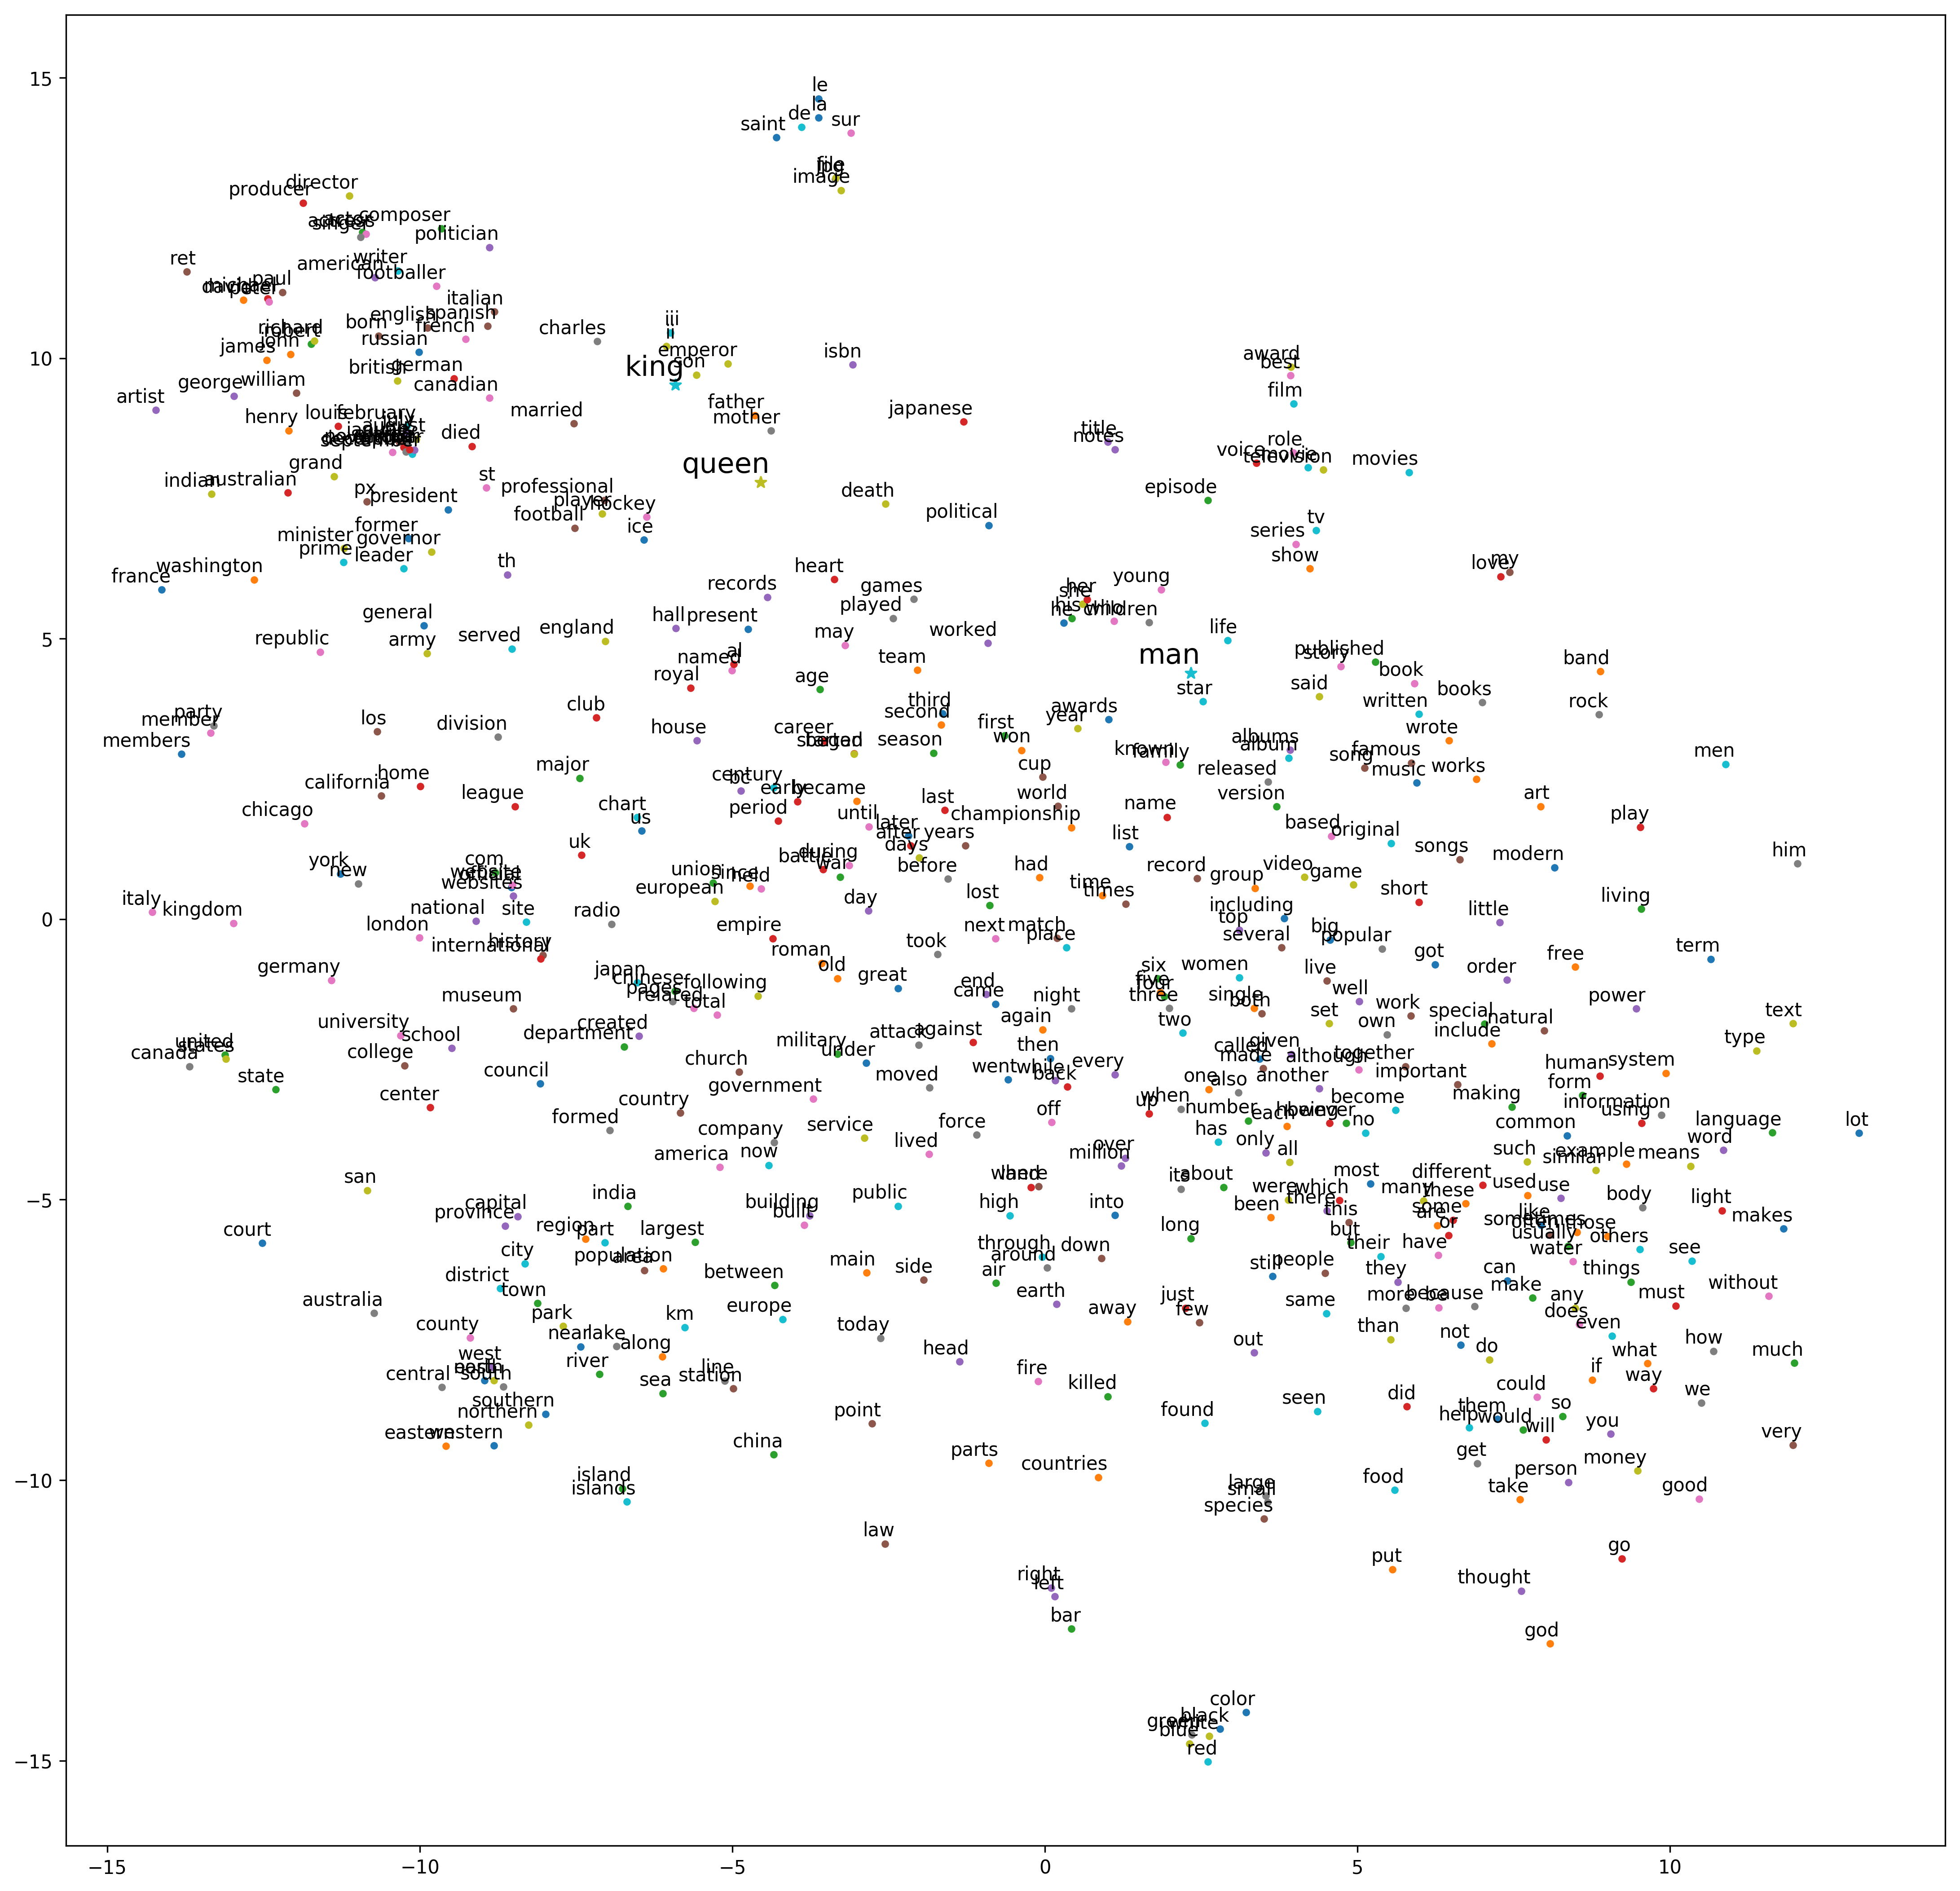

In [54]:
plotTSNE2D(plotted_word_num=500)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.158513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 145.475646
[t-SNE] Error after 5000 iterations: 1.304659


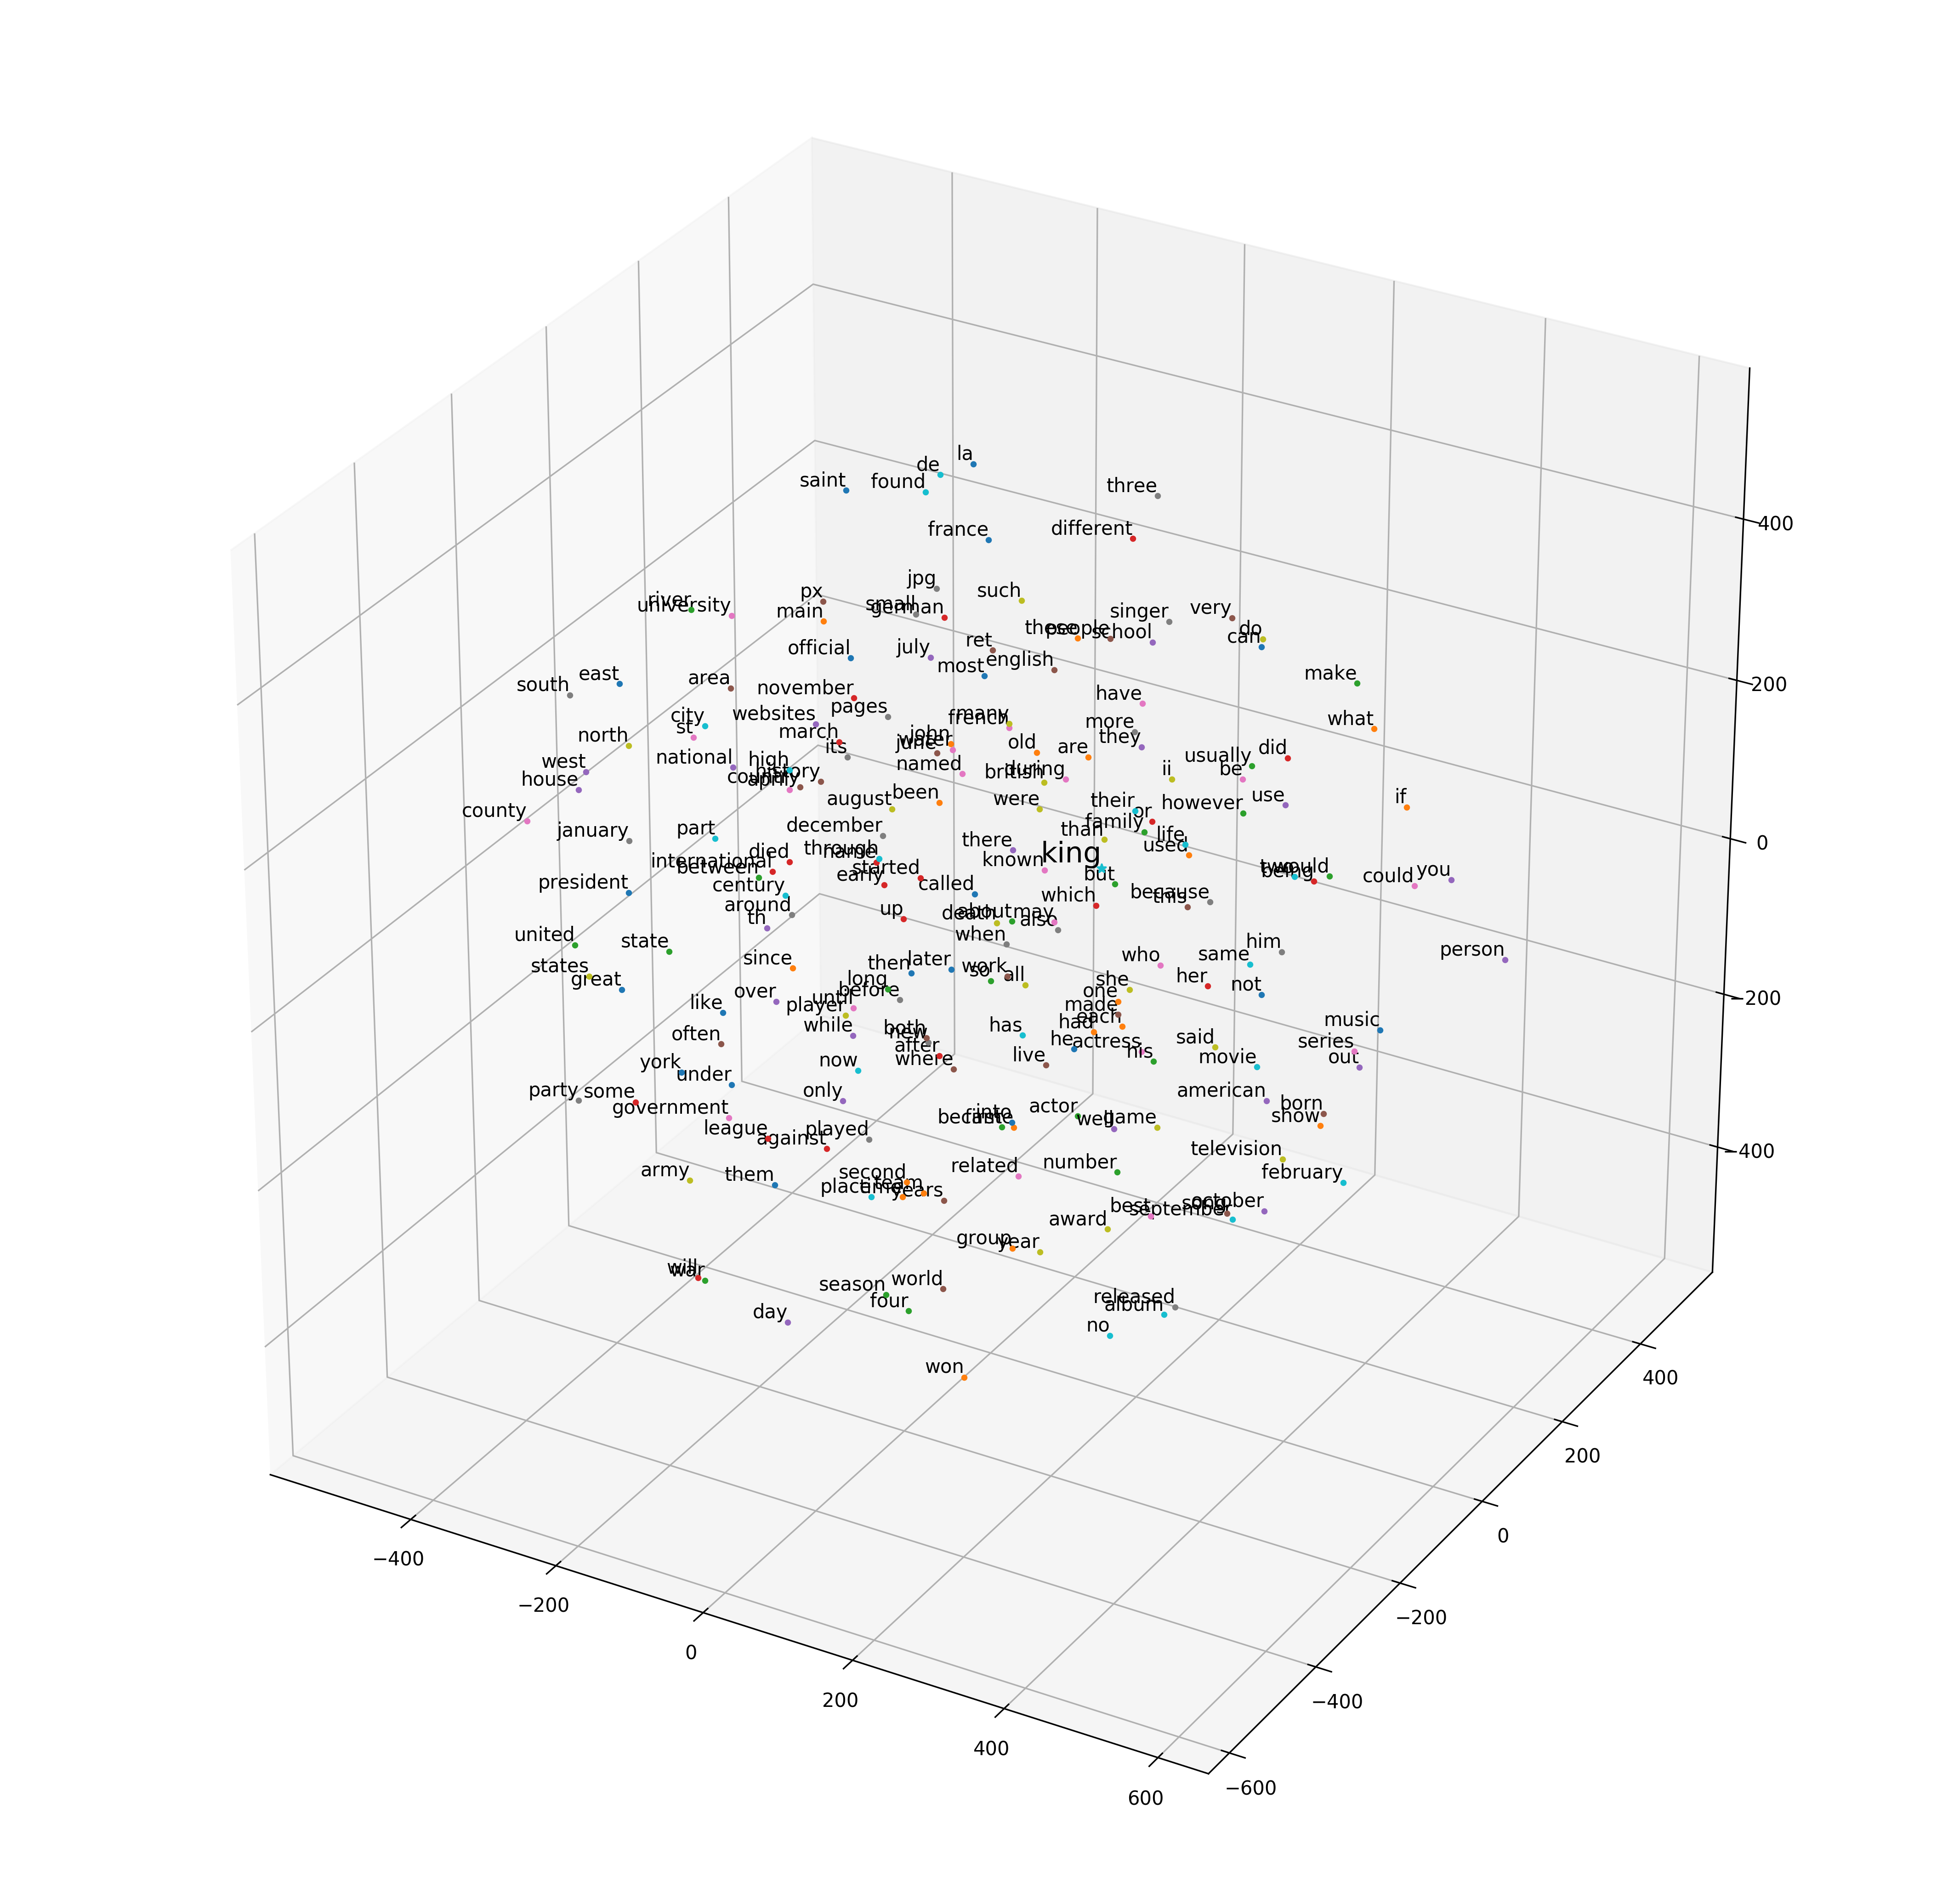

In [58]:
plotTSNE3D()

### 5. FastText
[FastText](https://arxiv.org/pdf/1607.04606.pdf) is a logical development of skip-gram model. The core feature is to present the word as the sum of its n-grams embeddings and its own embedding vector. For example, if we want to use only 3-grams, than word **fast** be reprented as n-grams **-fa**, **fas**, **ast**, **st-** and word **-fast-**. The context is encoeded in usual way, as a result similarity of word and context word is the following sum
$$s(w, c) = \sum_{n \in N_w} z^{T}_n v'_{c},$$
where $N_w$ is the set of all n-grams of word $w$ combined with word itself. The authors argue that the use of combination of 3-,4- and 5-grams helps to get better embeddings for rare and even unknown words (emdedding of word itself is null vector). For model training is proposed to use negative sampling.

You can find more information on [site](https://fasttext.cc) of FastText.

#### Exercises
1. Train FastText word embeddings ($d$=256).
2. Find some rare words in your corpus and find top-5 nearest words for them, using cosinus as metric.
3. Compare results with classic word2vec.
4. Invent some funny new word and found its top-5 nearest words again.
5. How could you compare all models. Suggest your metric (see papers for inspiration).

In [33]:
def build_dataset2(corpus):
    words = []
    print('INFO: extracting words from corpus')
    for text in tqdm(corpus.get_texts()):
        words.append([word for word in text])
    return words

ft_data = build_dataset2(wiki_corpus)

0it [00:00, ?it/s]

INFO: extracting words from corpus


87353it [01:27, 1003.52it/s]2018-02-10 18:26:28,038 : INFO : finished iterating over Wikipedia corpus of 87384 documents with 23340546 positions (total 243051 articles, 24725459 positions before pruning articles shorter than 50 words)
87384it [01:27, 1000.36it/s]


In [40]:
with open('ft_data.pickle', 'wb') as f:
    pickle.dump(ft_data, f)

In [ ]:
fasttext = FT_gensim(size=256, sg=1, workers=8, iter=5)
# build the vocabulary
fasttext.build_vocab(ft_data)

In [ ]:
fasttext.train(ft_data, total_examples=fasttext.corpus_count, epochs=fasttext.iter)

In [ ]:
fasttext.save('./fasttext_model/saved_model_fasttext')

Let's check our model. Starting with the already known test:

In [83]:
fasttext.wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.583054780960083),
 ('regnant', 0.5638098120689392),
 ('kingz', 0.5509213805198669),
 ('kingsmen', 0.5356711149215698),
 ('madwoman', 0.5341323614120483),
 ('husband', 0.5277038812637329),
 ('noblewoman', 0.5268806219100952),
 ('æthelred', 0.52210533618927),
 ('consort', 0.5195152163505554),
 ('kings', 0.5109816789627075)]

Next, we will try to find rare words in corpus and compare similarity outputs for `FastText` and `Word2Vec`:

In [95]:
len(t_dict)

68636

As we constructed our dictionary in decreasing order of occurrences, it's clear that all the rear words are placed at the end of the dictionary. I'll just manually took some not absolutely meaningless words from interval 65000-65200 of indices.

In [92]:
fasttext.wv.most_similar('deteriorating', topn=5)

[('deterioration', 0.9207093715667725),
 ('deteriorate', 0.8986635208129883),
 ('deteriorated', 0.8807905912399292),
 ('fluctuating', 0.7413010597229004),
 ('mediating', 0.7336662411689758)]

In [75]:
fasttext.wv.most_similar('democratization', topn=5)

[('democratie', 0.8444406986236572),
 ('democraten', 0.8402299880981445),
 ('undemocratic', 0.8382085561752319),
 ('democratic', 0.8371376395225525),
 ('liberalization', 0.823475182056427)]

In [86]:
fasttext.wv.most_similar('acknowledgement', topn=5)

[('acknowledgment', 0.934617817401886),
 ('acknowledge', 0.9142924547195435),
 ('acknowledges', 0.9004343748092651),
 ('acknowledging', 0.8940515518188477),
 ('acknowledged', 0.8683393001556396)]

In [85]:
fasttext.wv.most_similar('illuminate', topn=5)

[('illuminates', 0.9036293029785156),
 ('illuminated', 0.839796781539917),
 ('illuminati', 0.8236902952194214),
 ('illuminating', 0.8154810667037964),
 ('illuminatus', 0.8074674606323242)]

In [94]:
fasttext.wv.most_similar('monarchical', topn=5)

[('monarchist', 0.8324705362319946),
 ('monarchists', 0.8268142938613892),
 ('monarchies', 0.8221420049667358),
 ('monarchy', 0.8145143389701843),
 ('monarch', 0.7937329411506653)]

In [93]:
sgm = NLPModel(final_embeddings, t_dict, t_rev_dict, final_embeddings_norm)
sgm.print_nearest('deteriorating', 5, 'cosine')
sgm.print_nearest('democratization', 5, 'cosine')
sgm.print_nearest('acknowledgement', 5, 'cosine')
sgm.print_nearest('illuminate', 5, 'cosine')
sgm.print_nearest('monarchical', 5, 'cosine')

Nearest to deteriorating
           word   distance
   transcribing | 0.6430
          jokey | 0.6558
     tumultuous | 0.6575
          davao | 0.6655
          hallé | 0.6693

Nearest to democratization
           word   distance
      engineers | 0.6587
         ripens | 0.6620
       toontown | 0.6647
         denise | 0.6732
        duality | 0.6737

Nearest to acknowledgement
           word   distance
          fatou | 0.6734
         gernot | 0.6864
       intersex | 0.6872
  peloponnesian | 0.6892
        purpose | 0.6895

Nearest to illuminate
           word   distance
      labourers | 0.6446
      riverview | 0.6466
        frisbee | 0.6539
         sharyo | 0.6565
         inhale | 0.6595

Nearest to monarchical
           word   distance
        rodbell | 0.5513
     coincident | 0.5753
         duparc | 0.5813
    dishwashers | 0.5814
        dacians | 0.5851



From these examples we can understand that `fasttext's` most nearest words in terms of cosine metric are the derivatives of the word. On the contrary, `w2vec's` nearest words are relatively similar to the given by their meanings (they should have been better, if we trained on much larger dataset).

We can have some fun by trying to find similar tokens to uknown (or unreal) words: (10 nearest words will be shown as  it sometimes may be more representative)

In [101]:
fasttext.wv.most_similar('dongle')

[('yongle', 0.7788407802581787),
 ('donglu', 0.7420980930328369),
 ('dongji', 0.6840469837188721),
 ('dongdongju', 0.6802369356155396),
 ('dong', 0.6709597110748291),
 ('donglin', 0.66347336769104),
 ('dongfeng', 0.6581323742866516),
 ('taedong', 0.6459282040596008),
 ('muryeong', 0.643060564994812),
 ('dongjak', 0.6423587203025818)]

In [102]:
fasttext.wv.most_similar('pupok')

[('pupo', 0.7950046062469482),
 ('pupa', 0.6676948666572571),
 ('pup', 0.6583696007728577),
 ('puppis', 0.6214662790298462),
 ('pupae', 0.6100875735282898),
 ('pups', 0.6009665727615356),
 ('pupal', 0.5936557650566101),
 ('puppy', 0.5562628507614136),
 ('puppies', 0.5541257858276367),
 ('pugni', 0.538809061050415)]

In [103]:
fasttext.wv.most_similar('gogogox')

[('gogol', 0.7911245822906494),
 ('gogo', 0.7357502579689026),
 ('gog', 0.6997478008270264),
 ('gogos', 0.602120041847229),
 ('kabalevsky', 0.5589625835418701),
 ('koan', 0.5529186725616455),
 ('uladzimir', 0.5496048331260681),
 ('komisarjevsky', 0.543964684009552),
 ('dostoevsky', 0.5360696315765381),
 ('fyodor', 0.5341596603393555)]

In [113]:
fasttext.wv.most_similar('spidey')

[('spider', 0.8638204336166382),
 ('spiders', 0.8353186249732971),
 ('spiderwebs', 0.7672797441482544),
 ('spiderleg', 0.764175534248352),
 ('spidermonkey', 0.7626092433929443),
 ('spiderman', 0.723136305809021),
 ('spiderwick', 0.7167592644691467),
 ('silkmoth', 0.6028944253921509),
 ('ladybeetle', 0.5994311571121216),
 ('hispida', 0.5912513732910156)]

In [122]:
fasttext.wv.most_similar('dedlayn')

[('ashbrook', 0.6814638376235962),
 ('hadlee', 0.6680400371551514),
 ('dedham', 0.666149377822876),
 ('wyn', 0.6609863042831421),
 ('kurtwood', 0.6609096527099609),
 ('selwyn', 0.656642735004425),
 ('walbrook', 0.6560280323028564),
 ('wyck', 0.6541348695755005),
 ('hetfield', 0.6513575315475464),
 ('bedloe', 0.6511176228523254)]